<a href="https://colab.research.google.com/github/UCD-Physics/Python-HowTos/blob/main/Curve_fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting curves to data

To fit curves to data we use the `curve_fit()` function from the SciPy Optimize library. Note: this is the supported curve_fitting library and is the only one which can be used (unless approval is received from the staff member in charge of the experiment)

Curve fitting is used to find the optimum parameters for a function to describe the data.

## Background

More detailed background on errors, $\chi^2$ and curve fitting with `curve_fit()` can be found [here](https://physicslabs.ucd.ie/docs/data_analysis/).

### $\chi^2$ minimisation

`curve_fit()` performs a $\chi^2$ minimisation (i.e. it searches for the function parameters that minimize the $\chi^2$ sum) where

$$  \chi^2 = \sum_i \left[\frac{y_i - f(x_i, pars)}{\sigma_i} \right]^2$$

To make sure the errors on the data are taken into account for the $\chi^2$ minimisation you should provide the error bars (option `sigma=yerr`). If error bars are not specified then the errors are all assumed to be 1.0, which results in a least-squares fit. 

The curve fit function also treats the errors are relative weights unless you specify that they are real errors (option `absolute_sigma = True`). 

Correctly specifying real errors affects the accuracy of the errors on the fitted parameters.

### Initial Parameters

To curve-fitting function searches the parameters which minimise the $\chi^2$ sum by searching parameter space using an algorithm. The initial parameter values for the search are all 1.0 by default, unless you specify them with the `p0=` option. In many cases when fitting a non-linear function a local minimum may be found and not the true minimum of interest. Therefore, it is strongly recommended to overlay your fitting function with initial parameters and adjust until they are somewhat close, before running the `curve_fit` function with those close parameters specified using the `p0=` option. It is always advisable to overlay the best-fit curve 
  
### Return values

The `curve_fit()` function returns two arrays:
 * the array of optimum parameters (usually called `popt`) and
 * the covariance matrix (usually called `pcov`). 
 
The errors on the best-fit parameters are the square roots of the diagonal elements of the covariance matrix. 

### Goodness of fit

After the data has been fit the $\chi^2$ value and associated P-value for number of degrees of freedom can be calculated. Please see the slides on $\chi^2$ [here](https://physicslabs.ucd.ie/docs/data_analysis/).


### Basic curve_fit() )usage:

The most basic usage of `curve_fit()` is:
```python
popt, pcov = curve_fit(function, xdata, ydata, sigma=yerr, absolute_sigma=True, p0=initial_pars)
```

In [2]:
# first load the libraries

from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 16
plt.rcParams['savefig.bbox'] = 'tight'  
plt.rcParams['errorbar.capsize'] = 3

## Example: fitting straight line

In this example we will fit a straight line to some data which we download as a text file from the how-to github repository.

In [115]:
# download data file if you have not already!

!wget https://raw.githubusercontent.com/UCD-Physics/Python-HowTos/main/linear_data_with_errors.txt

In [4]:
# load date file

x, y, yerr = np.loadtxt("linear_data_with_errors.txt", unpack=True)

In [5]:
# define function for fitting

def line(x, m, c):
    """Straight line equation for generating data and fitting """
    return m * x + c

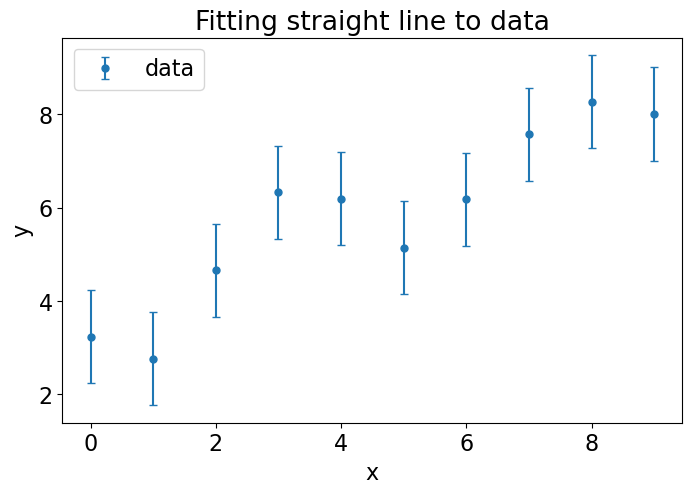

In [6]:
# plot the data and errors to make sure reasonable before fitting.

plt.errorbar(x, y, yerr, fmt="o", markersize=5, label="data")

plt.title("Fitting straight line to data")
plt.xlabel("x")
plt.ylabel("y");
plt.legend();

In [7]:
# perform curve fit
# 
# since it is a linear function we do not need initial parameter estimates.

popt, pcov = curve_fit(line, x, y, sigma=yerr, absolute_sigma=True)

print("popt:",popt)
print("pcov:",pcov)

popt: [0.57318597 3.25679247]
pcov: [[ 0.01212121 -0.05454545]
 [-0.05454545  0.34545455]]


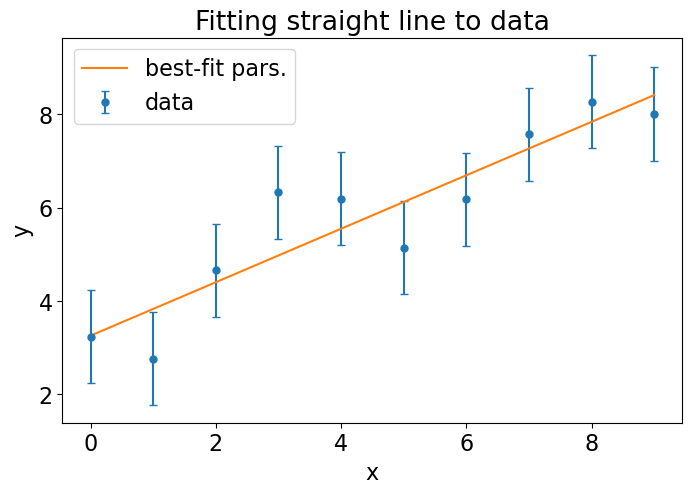

In [8]:
# plot the data + best-fit parameters

plt.errorbar(x, y, yerr, capsize=3, fmt="o", markersize=5, label="data")

plt.plot(x,line(x,*popt), label="best-fit pars.")

plt.title("Fitting straight line to data")
plt.xlabel("x")
plt.ylabel("y");
plt.legend();

In [9]:
# print best-fit pars and their errors

m_opt = popt[0]
c_opt = popt[1]
m_err = np.sqrt(pcov[0,0])
c_err = np.sqrt(pcov[1,1])

print("Best-fit parameters:")
print(f"m = {m_opt:.2f} ± {m_err:.2f}")
print(f"c = {c_opt:.2f} ± {c_err:.2f}")

Best-fit parameters:
m = 0.57 ± 0.11
c = 3.26 ± 0.59


### Is the fit good?

Evaluate the $\chi^2$ probability.


In [10]:
csq = np.sum(((y - line(x, *popt)) / yerr) ** 2)

ndof = len(x) - 2  # number of data points - number of parameters in fit function

print(f"χ2 / ndof = {csq:.1f}/{ndof}")

from scipy.stats import chi2

P = chi2.sf(csq, ndof)

print(f"P-value: {P:.2g}")

χ2 / ndof = 5.1/8
P-value: 0.74


## Example: fit an exponential decay

Curve fit can be used for any type of function, in the next example we will cover an exponential decay. First we'll import data (as seen in [this section](https://github.com/UCD-Physics/Python-HowTos/blob/main/Importing_Data.ipynb)).

In [ ]:
# download data:

!wget https://raw.githubusercontent.com/UCD-Physics/Python-HowTos/main/exp_data_errors.txt

In [11]:
xdata, ydata, ydata_err = np.loadtxt('exp_data_errors.txt', unpack = True)

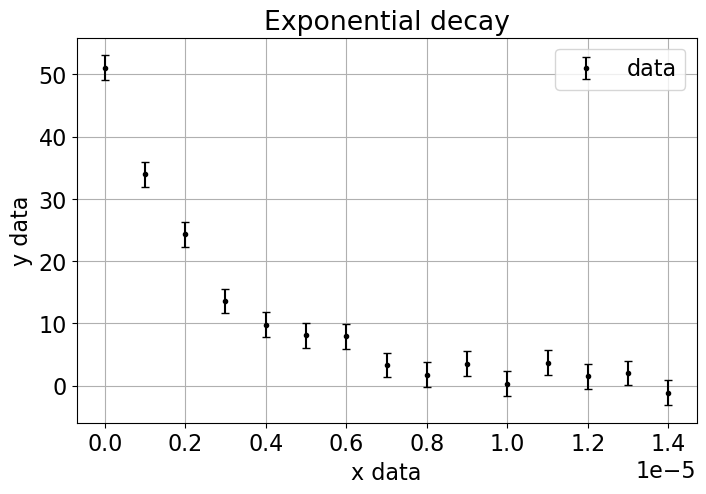

In [12]:
# plot the raw data

plt.errorbar(xdata, ydata, yerr=ydata_err, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('x data')
plt.ylabel('y data')
plt.legend(loc = 'upper right');
plt.title("Exponential decay");

For non-linear fitting, it is important to use a starting estimate in the `curve_fit` function. 

The best way to do this is to plot the function with a guess at the parameters over the data first to get an idea of the right values, adjust until they are in the right range, and then use these values in the function. 

For example, plot a generic exponential over the data (in this example $b e^{-ax}$)

In [13]:
def fexp(x,a,b):
    """Exponential function with no offset"""
    return a*np.exp(b*x)

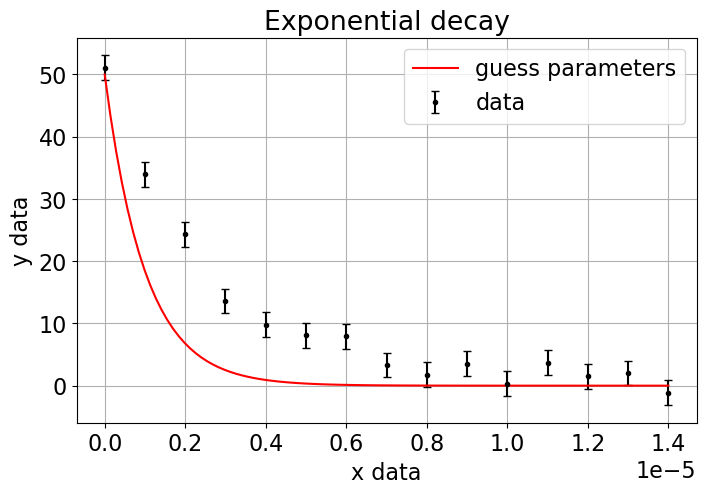

In [14]:
# plot the raw data
plt.errorbar(xdata, ydata, yerr=ydata_err, fmt=".", color = 'black', label = 'data')
plt.grid(True)
plt.xlabel('x data')
plt.ylabel('y data')


# initial guess
pars0 = (50, -1e6)

# overlay exponential 

x = np.linspace(0, max(xdata), 100)

plt.plot(x, fexp(x,*pars0), color = 'red', label = 'guess parameters')

plt.legend();
plt.title("Exponential decay");

While it is not perfect, it's a very close guess so now it is possible to use this value in the curve_fit function.

Decay constant (best-fit) = -3.8e+05 ± 2.3e+04


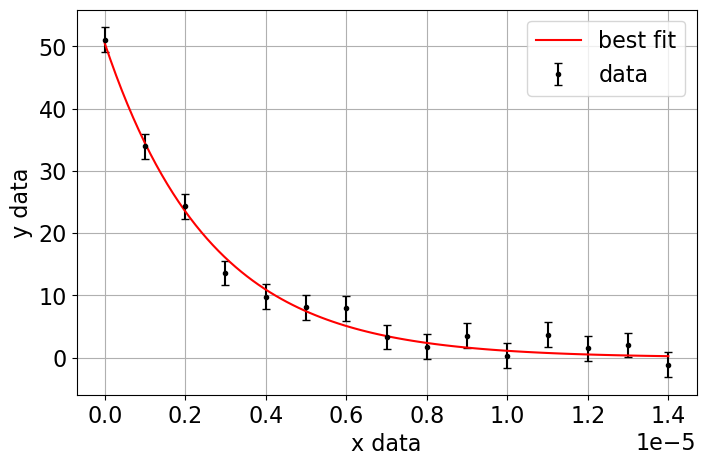

In [15]:
# perform fitting

popt, pcov = curve_fit(
    fexp, xdata, ydata, sigma=ydata_err, absolute_sigma=True, p0=pars0
)

# extract best-fit parameter and its error
b_opt = popt[1]
b_opt_err = np.sqrt(pcov[1, 1])
print(f"Decay constant (best-fit) = {b_opt:.2g} ± {b_opt_err:.2g}")

# plot data
plt.errorbar(xdata, ydata, yerr=ydata_err, fmt=".", color = 'black', label = 'data')

# creating x interval to include in y fit
x = np.linspace(0, max(xdata), 100)
y_fit = fexp(x, *popt)
plt.plot(x, y_fit, color="red", label="best fit")


plt.grid(True)
plt.xlabel("x data")
plt.ylabel("y data")
plt.legend();